In [5]:
import sqlite3
from pathlib import Path
import pandas as pd
import os
import descartes
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [6]:
%matplotlib inline

In [7]:
route_timepoints = pd.read_csv('StaticData/route_timepoints.txt')
routes = pd.read_csv('StaticData/routes.txt')
shapes = pd.read_csv('StaticData/shapes.txt')
stop_times = pd.read_csv('StaticData/stop_times.txt')
stops = pd.read_csv('StaticData/stops.txt')
trips = pd.read_csv('StaticData/trips.txt')

In [8]:
conn = sqlite3.connect('RIPTA.db')
trip_updates_df = pd.read_sql_query('SELECT * FROM trip_updates',conn)

In [9]:
trip_updates_df.head()

,id,update_timestamp,timestamp,trip_id,stop_id,delay
0,1,1564412522,1564412508,2854245,1835,-60
1,2,1564412522,1564412508,2854245,1895,-60
2,3,1564412522,1564412508,2854245,1890,-60
3,4,1564412522,1564412508,2854245,1870,-60
4,5,1564412522,1564412508,2854245,2020,-60


In [10]:
vehicle_positions_df = pd.read_sql_query('SELECT * FROM vehicle_positions',conn)

In [12]:
vehicle_positions_df.head()

,id,update_timestamp,trip_id,route_id,trip_start_time,trip_start_date,position_lat,position_lon,bearing,speed,current_status,stop_id,timestamp,vehicle_id
0,1,1564412671,2854185,14,10:45:00,20190729,41.725727,-71.43697,30,0.00000,2,6540,1564412611,919
1,2,1564412671,2854176,14,11:00:00,20190729,41.426353,-71.46856,105,16.09344,2,55,1564412623,927
2,3,1564412671,2854274,63,10:52:00,20190729,41.513508,-71.31724,195,11.62304,2,1895,1564412626,549
3,4,1564412671,2854245,63,10:45:00,20190729,41.509212,-71.31726,75,2.68224,2,1870,1564412621,1001
4,5,1564412671,2854273,63,10:22:00,20190729,41.491318,-71.31754,45,0.00000,1,1382,1564412619,1002


In [13]:
vehicle_positions_df.shape

(698, 14)

In [14]:
trip_updates_df.shape

(6668, 6)

In [15]:
###CHECK FOR DUPLICATES IN TRIP_UPDATES
trip_updates_df.duplicated(subset=['timestamp','trip_id','stop_id'],keep=False).value_counts()

False    6668
dtype: int64

In [16]:
###CHECK FOR DUPLICATES IN VEHICLE POSITIONS
vehicle_positions_df.duplicated(subset=['timestamp','position_lat','position_lon'],keep=False).value_counts()

False    698
dtype: int64

In [17]:
###ROUNDING TIMESTAMPS TO THE NEAREST 100 SECS TO INCREASE LIKELIHOOD OF MATCH BETWEEN TRIP_UPDATE TIMESTAMP 
###AND VEHICLE_POSITION TIMESTAMP
vehicle_positions_df['timestamp_rounded'] = round(vehicle_positions_df['timestamp'],-2)
vehicle_positions_df.head()

,id,update_timestamp,trip_id,route_id,trip_start_time,trip_start_date,position_lat,position_lon,bearing,speed,current_status,stop_id,timestamp,vehicle_id,timestamp_rounded
0,1,1564412671,2854185,14,10:45:00,20190729,41.725727,-71.43697,30,0.00000,2,6540,1564412611,919,1564412600
1,2,1564412671,2854176,14,11:00:00,20190729,41.426353,-71.46856,105,16.09344,2,55,1564412623,927,1564412600
2,3,1564412671,2854274,63,10:52:00,20190729,41.513508,-71.31724,195,11.62304,2,1895,1564412626,549,1564412600
3,4,1564412671,2854245,63,10:45:00,20190729,41.509212,-71.31726,75,2.68224,2,1870,1564412621,1001,1564412600
4,5,1564412671,2854273,63,10:22:00,20190729,41.491318,-71.31754,45,0.00000,1,1382,1564412619,1002,1564412600


In [18]:
trip_updates_df['timestamp_rounded'] = round(trip_updates_df['timestamp'],-2)
trip_updates_df.head()

,id,update_timestamp,timestamp,trip_id,stop_id,delay,timestamp_rounded
0,1,1564412522,1564412508,2854245,1835,-60,1564412500
1,2,1564412522,1564412508,2854245,1895,-60,1564412500
2,3,1564412522,1564412508,2854245,1890,-60,1564412500
3,4,1564412522,1564412508,2854245,1870,-60,1564412500
4,5,1564412522,1564412508,2854245,2020,-60,1564412500


In [19]:
###MATCHING VEHICLE POSITIONS WITH THEIR RESPECTIVE DELAY DATA
results = vehicle_positions_df.merge(trip_updates_df[['timestamp_rounded','trip_id','delay','stop_id']],
                                     on=['timestamp_rounded','trip_id','stop_id'],how='left')

In [20]:
results.duplicated(keep=False).value_counts()

False    698
dtype: int64

In [21]:
results.head()

,id,update_timestamp,trip_id,route_id,trip_start_time,trip_start_date,position_lat,position_lon,bearing,speed,current_status,stop_id,timestamp,vehicle_id,timestamp_rounded,delay
0,1,1564412671,2854185,14,10:45:00,20190729,41.725727,-71.43697,30,0.00000,2,6540,1564412611,919,1564412600,NaN
1,2,1564412671,2854176,14,11:00:00,20190729,41.426353,-71.46856,105,16.09344,2,55,1564412623,927,1564412600,NaN
2,3,1564412671,2854274,63,10:52:00,20190729,41.513508,-71.31724,195,11.62304,2,1895,1564412626,549,1564412600,NaN
3,4,1564412671,2854245,63,10:45:00,20190729,41.509212,-71.31726,75,2.68224,2,1870,1564412621,1001,1564412600,NaN
4,5,1564412671,2854273,63,10:22:00,20190729,41.491318,-71.31754,45,0.00000,1,1382,1564412619,1002,1564412600,NaN


In [22]:
###NUMBER OF BUSES THAT RAN ON TIME
results['delay'].isna().sum()

534

In [23]:
results['delay']=results['delay'].fillna(0)
results.head()

,id,update_timestamp,trip_id,route_id,trip_start_time,trip_start_date,position_lat,position_lon,bearing,speed,current_status,stop_id,timestamp,vehicle_id,timestamp_rounded,delay
0,1,1564412671,2854185,14,10:45:00,20190729,41.725727,-71.43697,30,0.00000,2,6540,1564412611,919,1564412600,0.0
1,2,1564412671,2854176,14,11:00:00,20190729,41.426353,-71.46856,105,16.09344,2,55,1564412623,927,1564412600,0.0
2,3,1564412671,2854274,63,10:52:00,20190729,41.513508,-71.31724,195,11.62304,2,1895,1564412626,549,1564412600,0.0
3,4,1564412671,2854245,63,10:45:00,20190729,41.509212,-71.31726,75,2.68224,2,1870,1564412621,1001,1564412600,0.0
4,5,1564412671,2854273,63,10:22:00,20190729,41.491318,-71.31754,45,0.00000,1,1382,1564412619,1002,1564412600,0.0


In [24]:
pvd_map = gpd.read_file('StaticData/pvdmap/geo_export_e37ca5c5-fc9d-45b0-b497-72b028d29c57.shp')
ri_map = gpd.read_file('StaticData/rimap/tl_2016_44_tract.shp')

In [25]:
geometry = [Point(xy) for xy in zip(results['position_lon'],results['position_lat'])]
geometry[:3]

In [26]:
geometry_stops = [Point(xy) for xy in zip(stops['stop_lon'],stops['stop_lat'])]
geometry_stops[:3]

In [27]:
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(results,crs=crs,geometry=geometry)
geo_df.head()

,id,update_timestamp,trip_id,route_id,trip_start_time,trip_start_date,position_lat,position_lon,bearing,speed,current_status,stop_id,timestamp,vehicle_id,timestamp_rounded,delay,geometry
0,1,1564412671,2854185,14,10:45:00,20190729,41.725727,-71.43697,30,0.00000,2,6540,1564412611,919,1564412600,0.0,POINT (-71.43697 41.7257271)
1,2,1564412671,2854176,14,11:00:00,20190729,41.426353,-71.46856,105,16.09344,2,55,1564412623,927,1564412600,0.0,POINT (-71.46856 41.4263535)
2,3,1564412671,2854274,63,10:52:00,20190729,41.513508,-71.31724,195,11.62304,2,1895,1564412626,549,1564412600,0.0,POINT (-71.31724 41.5135078)
3,4,1564412671,2854245,63,10:45:00,20190729,41.509212,-71.31726,75,2.68224,2,1870,1564412621,1001,1564412600,0.0,POINT (-71.31726 41.5092125)
4,5,1564412671,2854273,63,10:22:00,20190729,41.491318,-71.31754,45,0.00000,1,1382,1564412619,1002,1564412600,0.0,POINT (-71.31753999999999 41.4913177)


In [28]:
crs = {'init':'epsg:4326'}
geo_stops_df = gpd.GeoDataFrame(stops,crs=crs,geometry=geometry_stops)
geo_stops_df.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_associated_place,geometry
0,5,NaN,WESTERLY TOWN HALL,NaN,41.377000,-71.829771,NaN,NaN,0,NaN,NaN,POINT (-71.82977099999999 41.377)
1,10,NaN,GROVE NS WILCOX,NaN,41.378328,-71.826680,NaN,NaN,0,NaN,NaN,POINT (-71.82668000000001 41.378328)
2,20,NaN,WESTERLY RAILROAD STATION,NaN,41.381108,-71.829808,NaN,NaN,0,NaN,west,POINT (-71.829808 41.381108)
3,25,NaN,HIGH FS GROVE,NaN,41.381039,-71.825720,NaN,NaN,0,NaN,NaN,POINT (-71.82571999999999 41.381039)
4,50,NaN,BOON OPP PERKINS,NaN,41.424357,-71.460620,NaN,NaN,0,NaN,NaN,POINT (-71.46061999999999 41.424357)


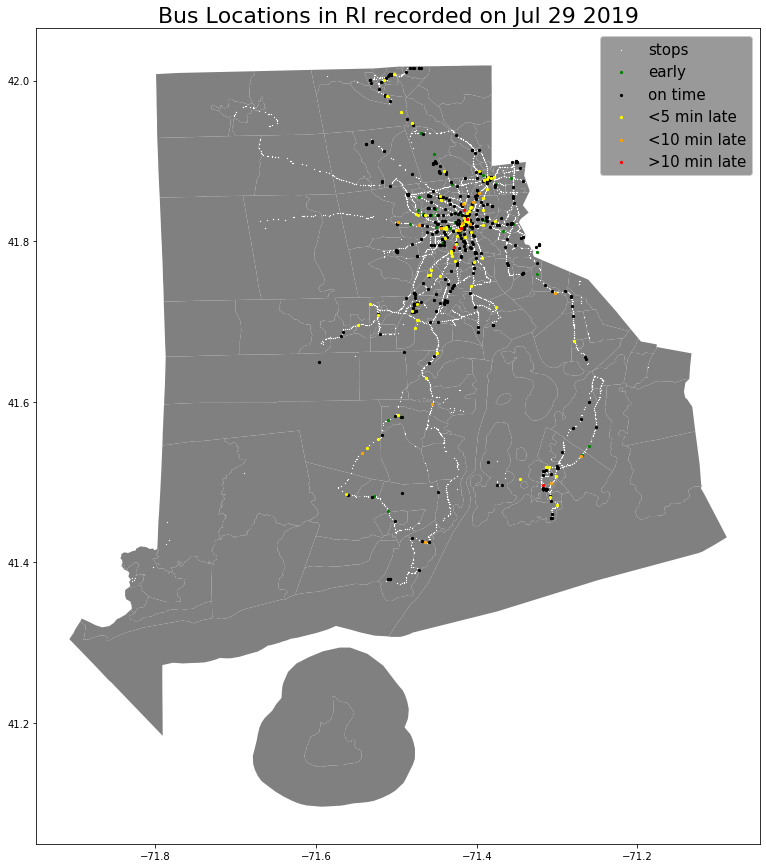

In [39]:
fig,ax = plt.subplots(figsize=(15,15))
ri_map.plot(ax=ax, color='grey')
geo_stops_df.plot(ax=ax,markersize=0.1,color='white',marker='x',label='stops')
geo_df[geo_df['delay']<0].plot(ax=ax,markersize=5,color='green',marker='o',label='early')
geo_df[geo_df['delay']==0].plot(ax=ax,markersize=5,color='black',marker='o',label='on time')
geo_df[geo_df['delay']<300][geo_df['delay']>0].plot(ax=ax,markersize=5,color='yellow',marker='o',label='<5 min late')
geo_df[geo_df['delay']<600][geo_df['delay']>300].plot(ax=ax,markersize=5,color='orange',marker='o',label='<10 min late')
geo_df[geo_df['delay']>600].plot(ax=ax,markersize=5,color='red',marker='o',label='>10 min late')
legend = plt.legend(prop={'size':15})
frame = legend.get_frame()
frame.set_facecolor('grey')
plt.title('Bus Locations and stops in RI recorded on Jul 29, 2019',fontsize=22)
plt.savefig('RI_RIPTA')

In [31]:
###IDENTIFYING (ROUGHLY) WHICH BUSES AND STOPS ARE IN PROVIDENCE (MAIN METRO AREA)
def inpvd(lon,lat):
    if -71.472716 < lon < -71.365464:
        if 41.787151 < lat < 41.858831:
            return True
    return False

geo_df['inpvd'] = [inpvd(x,y) for x,y in zip(geo_df['position_lon'],geo_df['position_lat'])]
geo_stops_df['indpvd'] = [inpvd(x,y) for x,y in zip(geo_stops_df['stop_lon'],geo_stops_df['stop_lat'])]

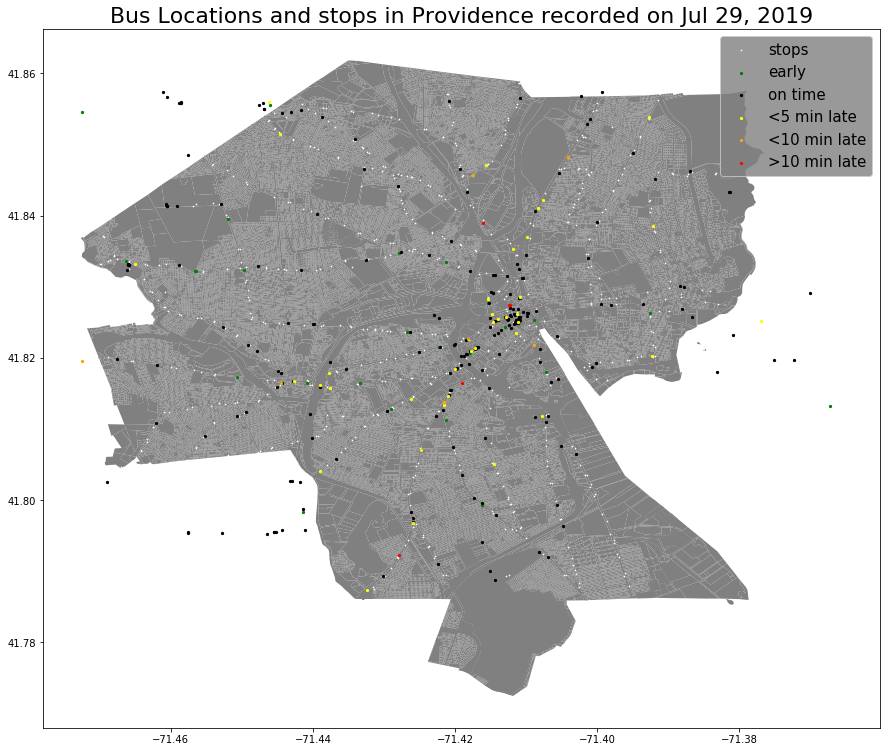

In [40]:
geo_df_pvd = geo_df[geo_df['inpvd']==True]
fig,ax = plt.subplots(figsize=(15,15))
pvd_map.plot(ax=ax, color='grey')
geo_stops_df[geo_stops_df['indpvd']==True].plot(ax=ax,markersize=0.5,color='white',marker='x',label='stops')
geo_df_pvd[geo_df['delay']<0].plot(ax=ax,markersize=5,color='green',marker='o',label='early')
geo_df_pvd[geo_df['delay']==0].plot(ax=ax,markersize=5,color='black',marker='o',label='on time')
geo_df_pvd[geo_df['delay']<300][geo_df['delay']>0].plot(ax=ax,markersize=5,color='yellow',marker='o',label='<5 min late')
geo_df_pvd[geo_df['delay']<600][geo_df['delay']>300].plot(ax=ax,markersize=5,color='orange',marker='o',label='<10 min late')
geo_df_pvd[geo_df['delay']>600].plot(ax=ax,markersize=5,color='red',marker='o',label='>10 min late')
legend = plt.legend(prop={'size':15})
frame = legend.get_frame()
frame.set_facecolor('grey')
plt.title('Bus Locations and stops in Providence recorded on Jul 29, 2019',fontsize=22)
plt.savefig('Providence_RIPTA')

In [69]:
inpvd_counts = []
inri_counts = []

inpvd_counts.append(geo_df[geo_df['inpvd']==True][geo_df['delay']<0]['inpvd'].count())
inpvd_counts.append(geo_df[geo_df['inpvd']==True][geo_df['delay']==0]['inpvd'].count())
inpvd_counts.append(geo_df[geo_df['inpvd']==True][geo_df['delay']>0][geo_df['delay']<300]['inpvd'].count())
inpvd_counts.append(geo_df[geo_df['inpvd']==True][geo_df['delay']>300][geo_df['delay']<600]['inpvd'].count())
inpvd_counts.append(geo_df[geo_df['inpvd']==True][geo_df['delay']>600]['inpvd'].count())
inri_counts.append(geo_df[geo_df['inpvd']==False][geo_df['delay']<0]['inpvd'].count())
inri_counts.append(geo_df[geo_df['inpvd']==False][geo_df['delay']==0]['inpvd'].count())
inri_counts.append(geo_df[geo_df['inpvd']==False][geo_df['delay']>0][geo_df['delay']<300]['inpvd'].count())
inri_counts.append(geo_df[geo_df['inpvd']==False][geo_df['delay']>300][geo_df['delay']<600]['inpvd'].count())
inri_counts.append(geo_df[geo_df['inpvd']==False][geo_df['delay']>600]['inpvd'].count())

inpvd_counts,inri_counts    

([26, 226, 37, 8, 5], [22, 308, 47, 8, 1])

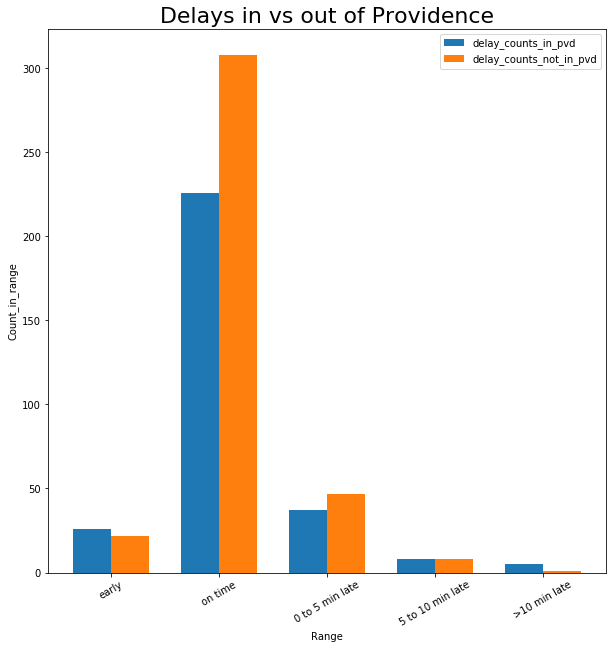

In [82]:
import numpy as np

fig,ax = plt.subplots(figsize=(10,10))
ind = np.arange(len(inri_counts))
width = 0.35
plt.bar(ind,inpvd_counts,width,label='delay_counts_in_pvd')
plt.bar(ind+width,inri_counts,width,label='delay_counts_not_in_pvd')
plt.ylabel('Count_in_range')
plt.xlabel('Range')
plt.xticks(ind+width/2,('early','on time','0 to 5 min late','5 to 10 min late','>10 min late'),rotation=30)
plt.legend(loc='best')
plt.title('Delays in vs out of Providence',fontsize=22)
plt.savefig('RIPTA_delays_bar')